# PPAC Analysis Notebook

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Load Data

In [2]:
data_dir = 'correlations/long_run_4mbar_500V/r56'
data_paths = {
    "coincident": Path(f"{data_dir}/coincident_imp.pkl"),
    "decay_candidates": Path(f"{data_dir}/decay_candidates.pkl"),
    "final_correlated": Path(f"{data_dir}/final_correlated.pkl"),
}
data = {}
for name, path in data_paths.items():
    if path.exists():
        data[name] = pd.read_pickle(path)
        print(f"Loaded {name}: {len(data[name])} rows")
    else:
        print(f"File {path} not found")

Loaded coincident: 27521 rows
Loaded decay_candidates: 4242 rows
Loaded final_correlated: 459 rows


## Basic Inspection

In [3]:
for name, df in data.items():
    display(df.head())

,imp_timetag,imp_x,imp_y,imp_tagx,imp_tagy,imp_nfile,imp_tdelta,imp_nX,imp_nY,imp_xE,...,dt_anodeH_ps,dt_cathode_ns,dt_anodeV_ns,dt_anodeH_ns,dt_cathode_us,dt_anodeV_us,dt_anodeH_us,dt_anodeH_us_corr,dt_anodeV_us_corr,dt_cathode_us_corr
0,365593579529,114,9,365593579529,365593535524,0,44005.0,2,1,6053.638672,...,-1451374.0,-1444.503,-1450.604,-1451.374,-1.444503,-1.450604,-1.451374,-1.451374,-1.450604,-1.444503
1,365593579529,114,10,365593579529,365593480005,0,99524.0,2,1,6053.638672,...,-1451374.0,-1444.503,-1450.604,-1451.374,-1.444503,-1.450604,-1.451374,-1.451374,-1.450604,-1.444503
2,384093270772,173,51,384093270772,384093141271,0,129501.0,1,1,31224.707031,...,-1492651.0,-1488.803,-1491.749,-1492.651,-1.488803,-1.491749,-1.492651,-1.492651,-1.491749,-1.488803
3,470220291371,25,40,470220291371,470220246747,0,44624.0,1,1,5044.895020,...,-1430721.0,-1423.804,-1430.465,-1430.721,-1.423804,-1.430465,-1.430721,-1.430721,-1.430465,-1.423804
4,582599788746,54,28,582599788746,582599769999,0,18747.0,1,1,919.400208,...,-1482943.0,-1477.002,-1484.937,-1482.943,-1.477002,-1.484937,-1.482943,-1.482943,-1.484937,-1.477002


,t,x,y,tagx,tagy,nfile,xboard,yboard,tdelta,nX,nY,xE,yE,event_type,recoil_index,recoil_time_sec,ppac_flag,is_clean,log_dt
0,4.943980,37,45,4943980152001,4943980120000,0,4,6,32001.0,1,1,409.484161,465.477936,imp,21,2.120573,both,False,1.037944
1,4.312688,27,36,4312688424002,4312688416004,0,4,7,7998.0,1,1,295.831024,328.630554,imp,30,3.807923,both,False,-0.683661
2,10.069237,21,39,10069236987995,10069237024494,0,4,6,-36499.0,1,2,786.344788,571.739990,imp,37,5.240201,both,False,1.574647
3,11.029816,147,48,11029816477996,11029816451993,0,0,7,26003.0,1,1,267.290619,302.731598,imp,39,5.543961,both,False,1.702173
4,26.473753,11,20,26473753261998,26473753246995,0,4,7,15003.0,1,1,326.817963,364.870331,imp,51,7.306380,both,False,2.953209


,recoil_x,recoil_y,recoil_xE,timetag,cathode_timetag,cathode_energy,anodeV_timetag,anodeV_energy,anodeH_timetag,anodeH_energy,...,alpha_y,alpha_t,alpha_xE,alpha_dt,chain,electron_x,electron_y,electron_t,electron_xE,electron_dt
0,72.0,56.0,7085.468750,1.057721e+14,1.057721e+14,3298.0,1.057721e+14,846.0,1.057721e+14,939.0,...,56.0,106.723890,8397.638672,0.951825,RA,NaN,NaN,NaN,NaN,NaN
1,73.0,56.0,7085.468750,1.057721e+14,1.057721e+14,3298.0,1.057721e+14,846.0,1.057721e+14,939.0,...,56.0,106.723890,8397.638672,0.951825,RA,NaN,NaN,NaN,NaN,NaN
2,90.0,13.0,4742.008789,1.352950e+14,1.352950e+14,3142.0,1.352950e+14,815.0,1.352950e+14,808.0,...,13.0,136.124174,8243.954102,0.829153,RA,NaN,NaN,NaN,NaN,NaN
3,115.0,41.0,6603.916992,2.453476e+14,2.453476e+14,3130.0,2.453476e+14,961.0,2.453476e+14,700.0,...,41.0,246.455303,8272.979492,1.107671,RA,NaN,NaN,NaN,NaN,NaN
4,99.0,51.0,5141.844238,2.484613e+14,2.484613e+14,4925.0,2.484613e+14,1404.0,2.484613e+14,1625.0,...,51.0,250.334145,8263.307617,1.872884,RA,NaN,NaN,NaN,NaN,NaN


## REA
Plot a histogram of recoil energies from the coincident events.

,recoil_x,recoil_y,recoil_xE,timetag,cathode_timetag,cathode_energy,anodeV_timetag,anodeV_energy,anodeH_timetag,anodeH_energy,...,alpha_y,alpha_t,alpha_xE,alpha_dt,chain,electron_x,electron_y,electron_t,electron_xE,electron_dt
457,48.0,14.0,6347.794922,1.704165e+15,1.704165e+15,3426.0,1.704165e+15,1224.0,1.704165e+15,810.0,...,14.0,1705.516934,8209.663086,0.622203,REA,48.0,14.0,1704.894731,574.437927,0.729888
458,132.0,22.0,6254.124512,2.983669e+15,2.983669e+15,3860.0,2.983669e+15,762.0,2.983669e+15,1629.0,...,22.0,2985.706274,8231.351562,1.960656,REA,132.0,22.0,2983.745618,338.261078,0.076929


2


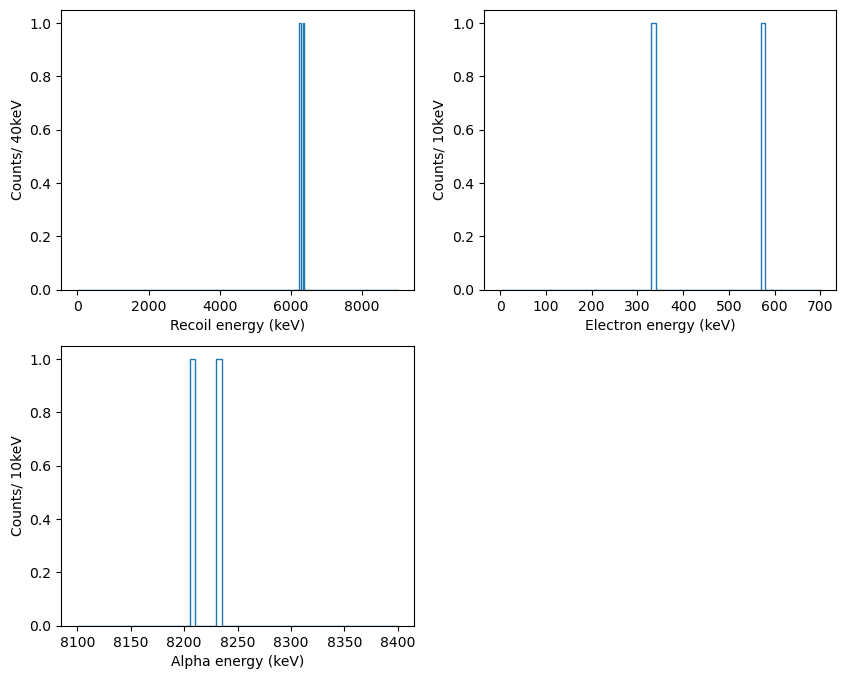

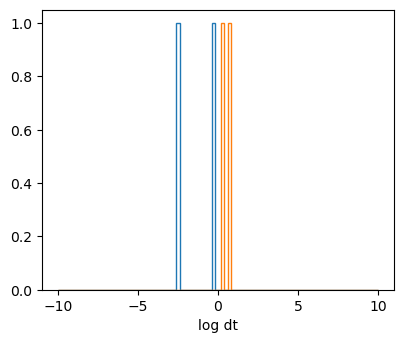

In [4]:
# Inspect
df = data["final_correlated"]
df_REA = df[df["chain"] == "REA"]
display(df_REA)
print(len(df_REA))

# plotting
# Plotting

if len(df_REA) >0:
    
    # Energies
    plt.figure(figsize=(10,8))
    plt.subplot(221)
    plt.hist(df_REA['recoil_xE'], histtype='step',bins=175, range=(0,9000))
    plt.xlabel('Recoil energy (keV)')
    plt.ylabel(r'Counts/ 40keV')
    plt.subplot(222)
    plt.hist(df_REA['electron_xE'], histtype='step',bins=70, range=(0,700))
    plt.xlabel('Electron energy (keV)')
    plt.ylabel(r'Counts/ 10keV')
    plt.subplot(223)
    plt.hist(df_REA['alpha_xE'], histtype='step', bins=60, range=(8100,8400))
    plt.xlabel('Alpha energy (keV)')
    plt.ylabel(r'Counts/ 10keV')
    plt.show()
    plt.close()
    
    # KHS plots 
    plt.figure(figsize=(10,8))
    plt.subplot(221)
    plt.hist(np.log(np.abs(df_REA['electron_t']-df_REA[r'recoil_t'])), histtype='step', bins =100, range=(-10,10))
    plt.xlabel('log dt')
    plt.subplot(221)
    plt.hist(np.log(np.abs(df_REA['alpha_t']-df_REA[r'recoil_t'])), histtype='step', bins =100, range=(-10,10))

# RE

,recoil_x,recoil_y,recoil_xE,timetag,cathode_timetag,cathode_energy,anodeV_timetag,anodeV_energy,anodeH_timetag,anodeH_energy,...,alpha_y,alpha_t,alpha_xE,alpha_dt,chain,electron_x,electron_y,electron_t,electron_xE,electron_dt
136,131.0,8.0,4195.422363,1.911885e+13,1.911885e+13,1986.0,1.911885e+13,748.0,1.911885e+13,224.0,...,NaN,NaN,NaN,NaN,RE,131.0,8.0,19.362720,325.391663,0.243866
137,56.0,46.0,2087.996094,2.921758e+13,2.921758e+13,1836.0,2.921758e+13,408.0,2.921758e+13,435.0,...,NaN,NaN,NaN,NaN,RE,56.0,46.0,29.663252,460.854401,0.445675
138,16.0,34.0,5759.331543,3.801750e+13,3.801750e+13,5814.0,3.801750e+13,2213.0,3.801750e+13,1613.0,...,NaN,NaN,NaN,NaN,RE,16.0,34.0,38.963418,422.877075,0.945919
139,100.0,49.0,2037.941772,5.792158e+13,5.792158e+13,2169.0,5.792158e+13,332.0,5.792158e+13,757.0,...,NaN,NaN,NaN,NaN,RE,100.0,49.0,58.875727,354.739258,0.954143
140,49.0,30.0,4686.947266,7.445254e+13,7.445254e+13,5093.0,7.445254e+13,1518.0,7.445254e+13,1758.0,...,NaN,NaN,NaN,NaN,RE,49.0,30.0,76.460589,577.574036,2.008049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,1.0,31.0,3222.599854,4.029796e+15,4.029796e+15,2918.0,4.029796e+15,671.0,4.029796e+15,877.0,...,NaN,NaN,NaN,NaN,RE,1.0,31.0,4033.084217,522.554871,3.288695
453,52.0,46.0,4130.085938,4.031509e+15,NaN,NaN,4.031509e+15,12.0,NaN,NaN,...,NaN,NaN,NaN,NaN,RE,52.0,46.0,4035.008008,296.391357,3.499110
454,3.0,57.0,3329.875488,4.051589e+15,4.051589e+15,1934.0,4.051589e+15,416.0,4.051589e+15,423.0,...,NaN,NaN,NaN,NaN,RE,3.0,57.0,4052.636623,332.513367,1.047817
455,25.0,51.0,4918.733887,4.062617e+15,4.062617e+15,4264.0,4.062617e+15,1020.0,4.062617e+15,1536.0,...,NaN,NaN,NaN,NaN,RE,25.0,51.0,4063.017848,421.568665,0.401089


321


Text(0, 0.5, 'Counts/ 10keV')

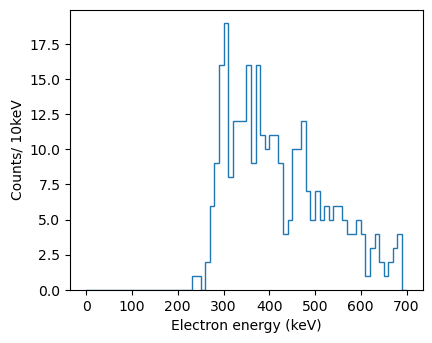

In [5]:
df = data["final_correlated"]
df_RE = df[df["chain"] == "RE"]
display(df_RE)
print(len(df_RE))
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.hist(df_RE['electron_xE'], histtype='step',bins=70, range=(0,700))
plt.xlabel('Electron energy (keV)')
plt.ylabel(r'Counts/ 10keV')

# RA

,recoil_x,recoil_y,recoil_xE,timetag,cathode_timetag,cathode_energy,anodeV_timetag,anodeV_energy,anodeH_timetag,anodeH_energy,...,alpha_y,alpha_t,alpha_xE,alpha_dt,chain,electron_x,electron_y,electron_t,electron_xE,electron_dt
0,72.0,56.0,7085.468750,1.057721e+14,1.057721e+14,3298.0,1.057721e+14,846.0,1.057721e+14,939.0,...,56.0,106.723890,8397.638672,0.951825,RA,NaN,NaN,NaN,NaN,NaN
1,73.0,56.0,7085.468750,1.057721e+14,1.057721e+14,3298.0,1.057721e+14,846.0,1.057721e+14,939.0,...,56.0,106.723890,8397.638672,0.951825,RA,NaN,NaN,NaN,NaN,NaN
2,90.0,13.0,4742.008789,1.352950e+14,1.352950e+14,3142.0,1.352950e+14,815.0,1.352950e+14,808.0,...,13.0,136.124174,8243.954102,0.829153,RA,NaN,NaN,NaN,NaN,NaN
3,115.0,41.0,6603.916992,2.453476e+14,2.453476e+14,3130.0,2.453476e+14,961.0,2.453476e+14,700.0,...,41.0,246.455303,8272.979492,1.107671,RA,NaN,NaN,NaN,NaN,NaN
4,99.0,51.0,5141.844238,2.484613e+14,2.484613e+14,4925.0,2.484613e+14,1404.0,2.484613e+14,1625.0,...,51.0,250.334145,8263.307617,1.872884,RA,NaN,NaN,NaN,NaN,NaN
5,70.0,19.0,6832.526367,2.533136e+14,2.533136e+14,3931.0,2.533136e+14,992.0,2.533136e+14,1236.0,...,19.0,257.465964,8229.701172,4.152323,RA,NaN,NaN,NaN,NaN,NaN
6,28.0,28.0,6233.135742,2.733332e+14,2.733332e+14,4558.0,2.733332e+14,1137.0,2.733332e+14,1628.0,...,28.0,274.842079,8227.242188,1.508911,RA,NaN,NaN,NaN,NaN,NaN
7,33.0,50.0,5156.288086,3.170994e+14,3.170994e+14,3070.0,3.170994e+14,1043.0,3.170994e+14,526.0,...,50.0,317.762204,8245.899414,0.662779,RA,NaN,NaN,NaN,NaN,NaN
8,111.0,41.0,4313.924316,6.243071e+14,6.243071e+14,4299.0,6.243071e+14,1920.0,6.243071e+14,746.0,...,41.0,625.530748,8223.617188,1.223640,RA,NaN,NaN,NaN,NaN,NaN


136


Text(0, 0.5, 'Counts/ 40keV')

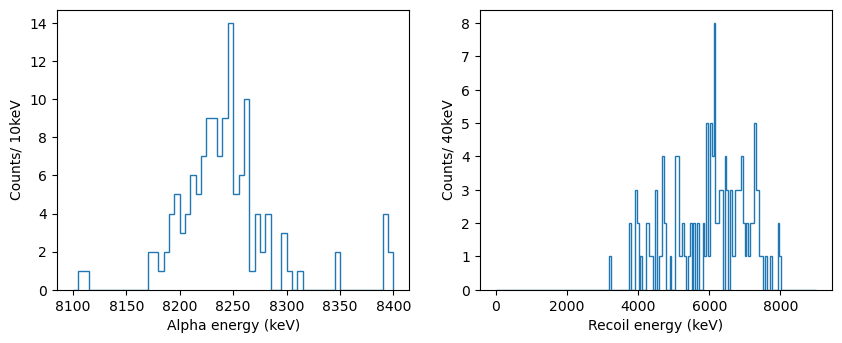

In [13]:
df = data["final_correlated"]
df_RA = df[df["chain"] == "RA"]
display(df_RA.iloc[:9])
print(len(df_RA))
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.hist(df_RA['alpha_xE'], histtype='step', bins=60, range=(8100,8400))
plt.xlabel('Alpha energy (keV)')
plt.ylabel(r'Counts/ 10keV')

plt.subplot(222)
plt.hist(df_RA['recoil_xE'], histtype='step',bins=175, range=(0,9000))
plt.xlabel('Recoil energy (keV)')
plt.ylabel(r'Counts/ 40keV')